# Construction of eulerian comparison point dataframe
- from L2 filtered data and field interpolation
- create a vaex.dataframe where each row is a point of comparison: 
['id',
 'time',
 'lat',
 'lon',
 'u_drifter',
 'v_drifter',
 'u_geo_swot',
 'v_geo_swot',
 'u_var_swot',
 'v_var_swot',
 'u_geo_nadir',
 'v_geo_nadir',
 'u_var_nadir',
 'v_var_nadir']

In [1]:
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt


path_data = './save_data/eulerian_dataframes/'
path_save_plot = './save_plots/save_plots_2024-06-19_Eulerian_comparison'

bbox_drifters = [0, 13.5, 36.5, 44]

#### utils

In [3]:
def restrain_domain(ds, min_lon, max_lon, min_lat, max_lat):
    extend = (min_lon <= ds.longitude) & (ds.longitude <= max_lon) & (min_lat <= ds.latitude) & (ds.latitude <= max_lat)
    in_biscay = (ds.longitude <= -0.1462) & (ds.latitude >= 43.2744)
    in_blacksea = (ds.longitude >= 27.4437) & (ds.latitude >= 40.9088)
    
    mask = extend & ~(in_biscay | in_blacksea) # exclude biscay and black sea
    return ds.where(mask, drop=True)



def plot2d(lon, lat, data, bbox: tuple=bbox_drifters, cmap='Oranges', center_bar=False, fraction_cbar=0.033,  title= None, save_name=None):
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    if center_bar:
        vmax = np.nanmax(np.abs(data))
        vmin = - vmax
    else:
        vmax = np.nanmax(data)
        vmin = np.nanmin(data)

    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)

    # Add a color bar to show the density scale
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')


    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        ax.set_title(save_name)
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

## Eulerian comparison

In [5]:
#open dataframe
df_raw = vaex.open(os.path.join(path_data, 'file_lowess_30min_vs02.hdf5'))

print('Number of observations : ', len(df_raw))

df = df_raw

select_domain = False
if select_domain:
    trace_domain = (3, 6, 37.5, 43.5)
    lon_min, lon_max, lat_min, lat_max = trace_domain
    df = vaex.from_pandas(df_raw[(df_raw['lat'] >= lat_min) & (df_raw['lat'] <= lat_max) & (df_raw['lon'] >= lon_min) & (df_raw['lon'] <= lon_max)])

    print('Number of observations selected : ', len(df))

df[:3]

Number of observations :  195825


#,id,time,lat,lon,u_drifter,v_drifter,u_geo_swot,v_geo_swot,u_var_swot,v_var_swot,u_geo_nadir,v_geo_nadir,u_var_nadir,v_var_nadir
0,300534061395960,2023-05-04 20:30:00.000000000,40.8508,4.9235,0.0455383,0.0959978,0.0420366,0.0262677,0.0463397,0.0349205,0.0592799,0.013968,0.0640365,0.0189936
1,300534061395960,2023-05-04 21:30:00.000000000,40.8597,4.92465,0.0442888,0.108926,0.050871,0.0230629,0.0559116,0.0316002,0.0655548,0.010675,0.0705687,0.0155742
2,300534061395960,2023-05-04 22:30:00.000000000,40.8603,4.92489,0.0432868,0.121092,0.0509073,0.0229523,0.0559511,0.031494,0.0659817,0.0104746,0.07103,0.015383


In [6]:
# compute metrics
df['L2_norm_geoswot'] = np.sqrt( (df.u_geo_swot - df.u_drifter)**2 + (df.v_geo_swot - df.v_drifter)**2)
df['L2_norm_varswot'] = np.sqrt( (df.u_var_swot - df.u_drifter)**2 + (df.v_var_swot - df.v_drifter)**2)
df['L2_norm_geonadir'] = np.sqrt( (df.u_geo_nadir - df.u_drifter)**2 + (df.v_geo_nadir - df.v_drifter)**2)
df['L2_norm_varnadir'] = np.sqrt( (df.u_var_nadir - df.u_drifter)**2 + (df.v_var_nadir - df.v_drifter)**2)

U_drifter = df.u_drifter.values + 1j * df.v_drifter.values

U_geoswot = df.u_geo_swot.values + 1j * df.v_geo_swot.values
U_varswot = df.u_var_swot.values + 1j * df.v_var_swot.values
U_geonadir = df.u_geo_nadir.values + 1j * df.v_geo_nadir.values
U_varnadir = df.u_var_nadir.values + 1j * df.v_var_nadir.values

df['diffarg_geoswot'] = np.angle(U_geoswot) - np.angle(U_drifter) 
df['diffarg_varswot'] = np.angle(U_varswot) - np.angle(U_drifter) 
df['diffarg_geonadir'] = np.angle(U_geonadir) - np.angle(U_drifter) 
df['diffarg_varnadir'] = np.angle(U_varnadir) - np.angle(U_drifter) 

df['diffabs_geoswot'] = np.abs(U_geoswot) - np.abs(U_drifter) 
df['diffabs_varswot'] = np.abs(U_varswot) - np.abs(U_drifter) 
df['diffabs_geonadir'] = np.abs(U_geonadir) - np.abs(U_drifter) 
df['diffabs_varnadir'] = np.abs(U_varnadir) - np.abs(U_drifter) 

In [7]:
# defines the grid to apply statistics
resolution = 0.2 #°
lon_grid = np.arange(df.lon.min(), df.lon.max(), resolution)
lat_grid = np.arange(df.lat.min(), df.lat.max(), resolution)

n_lat, n_lon = lat_grid.shape[0], lon_grid.shape[0]
print('resolution : ', resolution, '\ngrid shape (lat, lon): ', n_lat, n_lon)


# Compute the means on the grid
columns_to_mean = df.column_names[4:]
mean_grid = {col: df.mean(df[col], binby=[df['lon'], df['lat']], shape=(n_lon, n_lat)).T for col in columns_to_mean}

resolution :  0.2 
grid shape (lat, lon):  47 92


## Plots

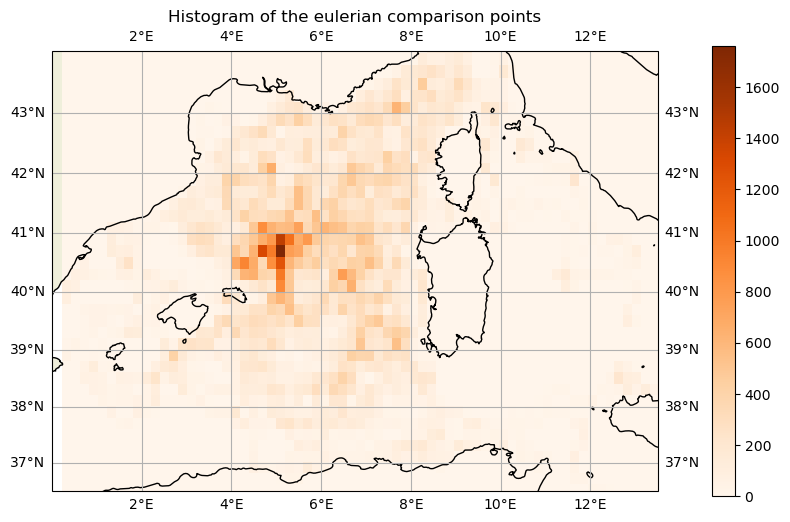

In [8]:
hist, lat_edges, lon_edges = np.histogram2d(df.lat.values, df.lon.values, bins=(n_lat, n_lon), range=None, density=False)
plot2d(lon_edges, lat_edges, hist, title='Histogram of the eulerian comparison points')

### Compa cyclo/geo for each satellite

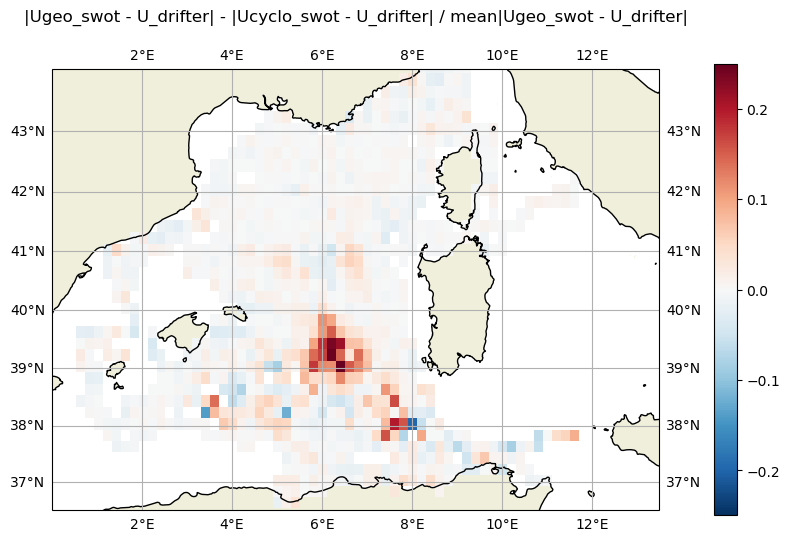

In [9]:

#      SWOT

# $\| U_{geos_swot} - U_{drifter} \| - \| U_{cyclo_swot} - U_{drifter} \|$

compa_cyclogeo_swot = mean_grid['L2_norm_geoswot'] - mean_grid['L2_norm_varswot']
relative_compa_cyclogeo_swot = compa_cyclogeo_swot/np.nanmean(mean_grid['L2_norm_geoswot'])

plot2d(lon_grid, 
       lat_grid, 
       relative_compa_cyclogeo_swot, 
       
       cmap='RdBu_r', center_bar=True, 
       
       title='|Ugeo_swot - U_drifter| - |Ucyclo_swot - U_drifter| / mean|Ugeo_swot - U_drifter|\n')

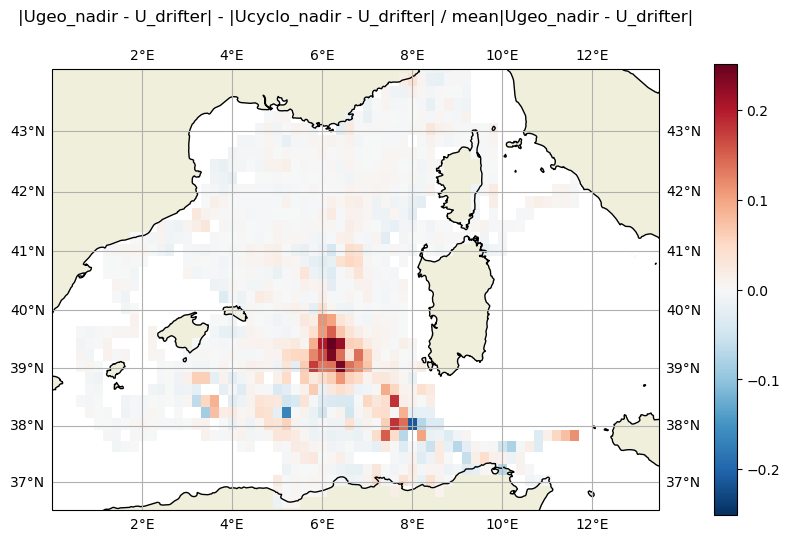

In [10]:

#      NADIR

# $\| U_{geos_swot} - U_{drifter} \| - \| U_{cyclo_swot} - U_{drifter} \|$

compa_cyclogeo_nadir = mean_grid['L2_norm_geonadir'] - mean_grid['L2_norm_varnadir']
relative_compa_cyclogeo_nadir = compa_cyclogeo_nadir/np.nanmean(mean_grid['L2_norm_geonadir'])

plot2d(lon_grid, 
       lat_grid, 
       relative_compa_cyclogeo_nadir, 
       
       cmap='RdBu_r', center_bar=True, 
       
       title='|Ugeo_nadir - U_drifter| - |Ucyclo_nadir - U_drifter| / mean|Ugeo_nadir - U_drifter|\n')

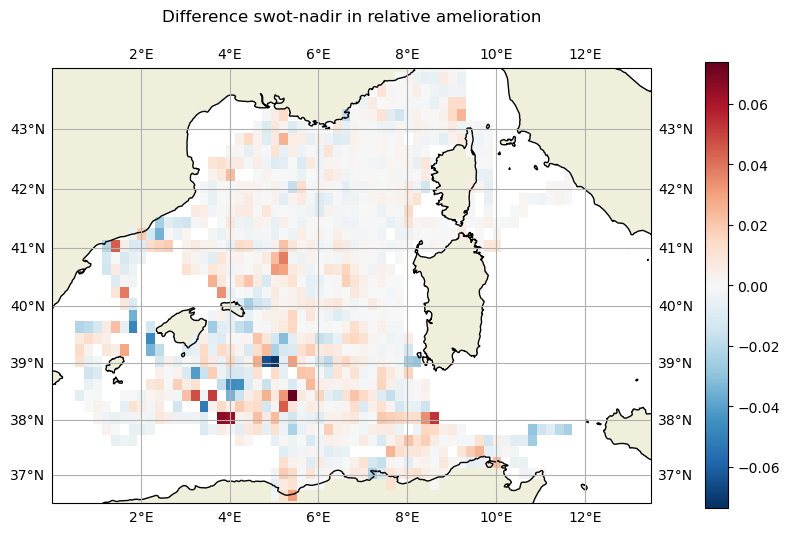

In [11]:
plot2d(lon_grid, 
       lat_grid, 
       relative_compa_cyclogeo_swot - relative_compa_cyclogeo_nadir, 
       
       cmap='RdBu_r', center_bar=True, 
       
       title='Difference swot-nadir in relative amelioration\n'
       )

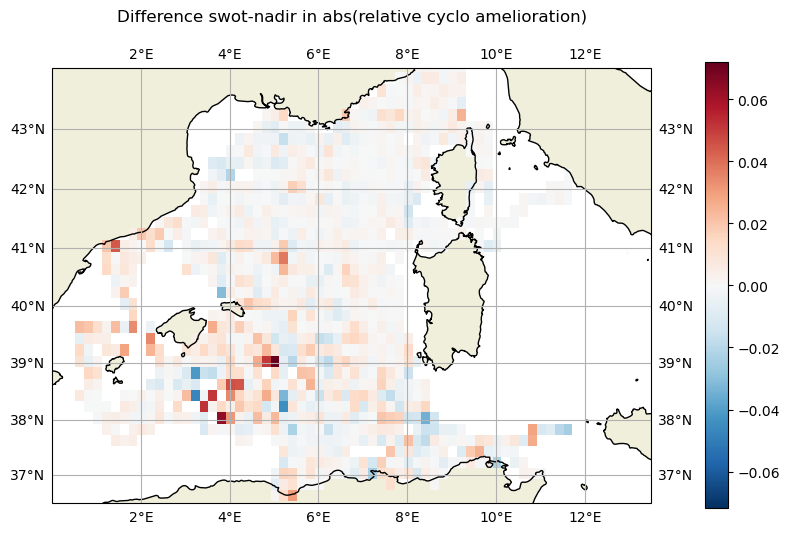

In [12]:
plot2d(lon_grid, 
       lat_grid, 
       np.abs(relative_compa_cyclogeo_swot) - np.abs(relative_compa_cyclogeo_nadir), 
       
       cmap='RdBu_r', center_bar=True, 
       
       title='Difference swot-nadir in abs(relative cyclo amelioration)\n'
       )

### Compa field/drifter : Velocities L2 norm

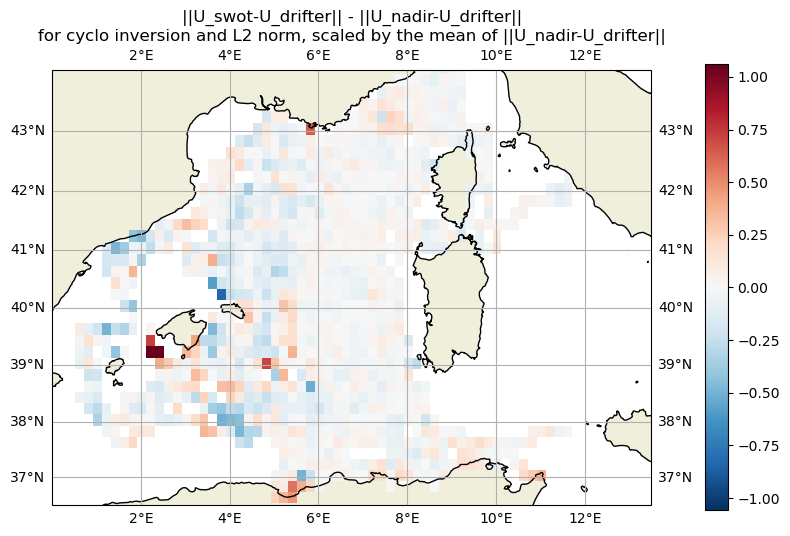

In [13]:
#plot2d(lon_grid, lat_grid, mean_grid['L2_norm_varswot'])
#plot2d(lon_grid, lat_grid, mean_grid['L2_norm_varnadir'])

compa_norma = (mean_grid['L2_norm_varswot'] - mean_grid['L2_norm_varnadir']) / np.nanmean(mean_grid['L2_norm_varnadir'])
plot2d(lon_grid, lat_grid, compa_norma, cmap='RdBu_r', center_bar=True, title='||U_swot-U_drifter|| - ||U_nadir-U_drifter||\nfor cyclo inversion and L2 norm, scaled by the mean of ||U_nadir-U_drifter||')  #'Relative difference in L2 norms on velocities between swot and nadir (cyclo)')

In [2]:
plt.hist( (compa_norma*hist).flatten(), bins=50)
np.nanmean(compa_norma)

NameError: name 'plt' is not defined

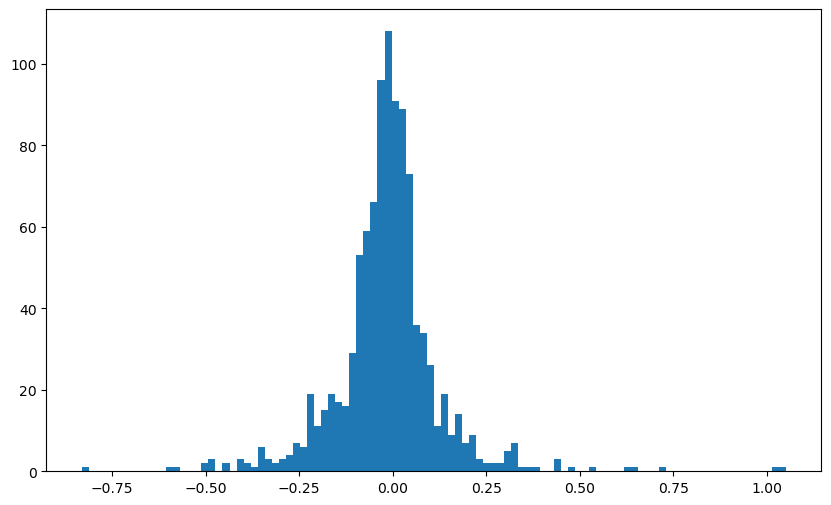

In [17]:
np.nanmean(compa_norma), np.nanstd(compa_norma), np.nanmedian(compa_norma)
np.nanmax(compa_norma)
compa_norma_noextrem = compa_norma[np.abs(compa_norma)< 2*np.nanstd(compa_norma)]
np.nanstd(compa_norma_noextrem)
plt.figure(figsize=(10,6))
a=plt.hist(compa_norma[~np.isnan(compa_norma)], bins=100)

### arg/abs differences

84.60957117990063

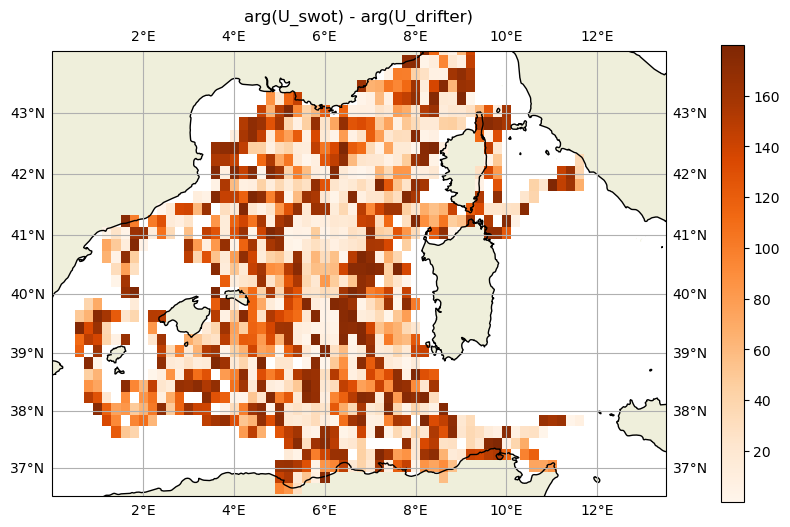

In [18]:
diffarg_varswot = np.abs(mean_grid['diffarg_varswot']*180/np.pi %180)

plot2d(lon_grid, lat_grid, diffarg_varswot, cmap='Oranges', center_bar=False, title='arg(U_swot) - arg(U_drifter)')
#plot2d(lon_grid, lat_grid, np.abs( mean_grid['diffarg_varnadir']*180/np.pi %180), cmap='Oranges', center_bar=False, title='arg(U_nadir) - arg(U_drifter)')
np.nanmean(diffarg_varswot)

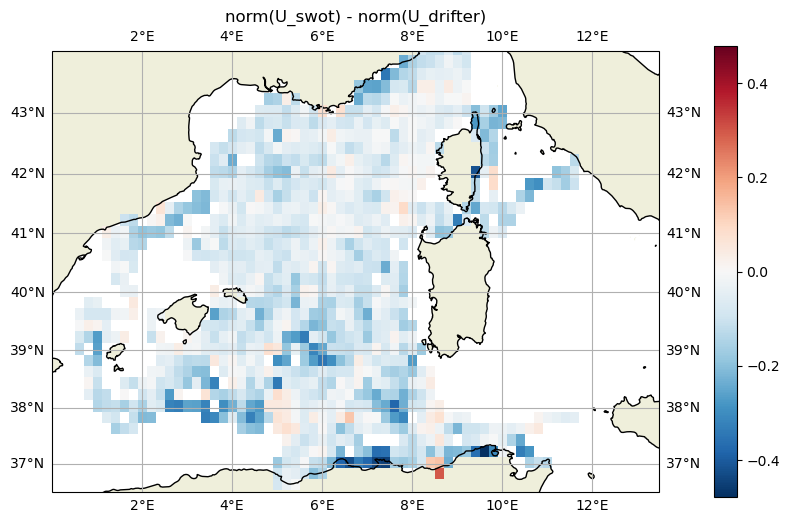

In [19]:
plot2d(lon_grid, lat_grid, mean_grid['diffabs_varswot'], cmap='RdBu_r', center_bar=True, title='norm(U_swot) - norm(U_drifter)')

In [20]:
data = mean_grid['diffabs_varswot'].flatten()
np.nanmean(data), np.nanstd(data)

(-0.08485637044578531, 0.08617845937361276)

In [21]:
np.abs(U_drifter).mean()

0.17930666121711936

In [22]:
np.nanmean(np.abs(U_varswot))

0.11935876148974732